# ENSF619 Assignment 02 - Tutorial Creation

## Philip Ciunkiewicz (10161276)

The purpose of this tutorial is to show how to approach and solve an interesting problem in deep learning using techniques relevant to the course. The topic of this tutorial will be self-supervised learning, drawing inspiration from this [PyTorch Lightning tutorial](https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/13-contrastive-learning.html). This notebook is designed to run in Google Colab and was developed in Google Colab. All supporting datasets, files, and models are downloaded during runtime.

## Introduction

Self-supervised learning is a category of machine learning (ML) techniques that operate on unlabeled data, similar to unsupervised learning. The difference between self-supervised and unsupervised learning comes from the formulation of a pretext task and downstream application to supervised problems. Pretext tasks are formulated as supervised problems by generating target labels from unlabeled data. The formulation of the pretext task is the most challenging and important component of self-supervised learning, and heavily influences the success achieved in tackling downstream problems.

Examples of pretext tasks include:
 - predicting future or past information in sequences
 - filling in missing information in sequences
 - predicting hidden/occluded information from images
 - predicting relative position/context from image patches
 - predicting transformations applied to an image
 - contrastive learning

Once a model has been trained on some unlabeled data for the pretext task, it can be adapted to downstream tasks through knowledge transfer. This step can include fine-tuning (effectively updating) the model weights or freezing the weights and introducing a classifier or other network architecture.

## Google Colab Package Installs
These are packages not available by default on the Colab environment, install before running via pip by running the cell below.

In [1]:
! pip install --quiet torch torchmetrics pytorch-lightning==1.9.3 torchvision seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 49.6 MB/s eta 0:00:00


## Checking GPU Availability
With Google Colab you can use GPU instances, this printout will show details on which GPU is available for hardware acceleration. Depending on the GPU chosen, the models can be trained rather quickly. It is recommended to use a GPU if possible.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 26 18:49:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

For this tutorial, we will make use of PyTorch Lightning along with a variety of other packages. PyTorch Lightning is an extension to Pytorch which enables researchers to more rapidly experiment and develop their deep learning models in PyTorch by eliminating much of the boilerplate that is required.

Along with PyTorch Lightning, we will need PyTorch itself, as well as TorchVision. PyTorch core gives us access to everything we need to build our networks, while TorchVision provides us with common image transformations as well as fast access to datasets.

From the standard library, we use the operating system (os) library for checking files and cpu cores, the logging library for a better alternative to print statements in our running code, urllib for downloading models from Github, and pathlib for dealing with file paths.

We will also use matplotlib for displaying our sample data and tqdm for dendering progress on our data transformations.

In [1]:
# Standard library imports
import os
import logging
import urllib
from copy import deepcopy
from pathlib import Path
from urllib.error import HTTPError

# Third-party library imports
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# TorchVision
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10, StanfordCars

# Creating global logger
LOG = logging.getLogger('tutorial.ipynb')
LOG.setLevel(logging.INFO)

NUM_WORKERS = os.cpu_count()

# Try to use GPU (either metal or cuda api), fall back to CPU
if torch.backends.mps.is_available():
    torch.backends.mps.determinstic = True
    torch.backends.mps.benchmark = False
    device = torch.device('mps')
elif torch.cuda.is_available():
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

LOG.info(f'Hardware accelerator: {device}')
LOG.info(f'Number of cpu cores: {NUM_WORKERS}')

INFO:tutorial.ipynb:Hardware accelerator: cuda
INFO:tutorial.ipynb:Number of cpu cores: 2


## Transforming Data

The particular algorithm we will use for self-supervised learning is taken from the paper [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf), and is referred to as SimCLR (specifically SimCLR v2 with this approach). This approach uses the pretext task of associating two heavily transformed images from the same source with eachother, hence the name Contrastive Learning. We are trying to teach the network to identify contextual features within images and relate them to each other. This approach has been shown to result in fairly strong learning of underlying feature representations in images.

In order to prepare the data for both the pretext and downstream tasks, we need to write a class for handling the transformations. TorchVision datasets perform transformations on-load so it is convenient for us to define this convenience class. The class will define two transformation pipelines, one with the flow for contrastive self-learning, and one to simply prepare images for any arbitrary downstream learning task. These pipelines are composed using TorchVision transforms.Compose.

The simclr pipeline for transformations includes a variety of randomly applied transformations, including horizontal flipping, resized cropping, color jitter, grayscale, and gaussian blur. The downstream pipeline for transformations includes only resizing. Both of the pipelines then convert the images to tensors and normalize them.

In [2]:
class SimCLRTransform:
    """
    Dataset transformation utility class
    """
    # Defining contrastive learning pipeline and downstream task pipeline
    simclr_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=(96, 96)),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.5, 
            contrast=0.5, 
            saturation=0.5, 
            hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    downstream_pipeline = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    def __init__(self, mode, outputs=2):
        assert mode in {'self-supervised', 'downstream'}
        self.mode = mode
        self.outputs = outputs

    def __call__(self, img):
        # Applying pipeline based on chosen mode
        if self.mode == 'self-supervised':
            return [self.simclr_pipeline(img) for _ in range(self.outputs)]
        elif self.mode == 'downstream':
            return self.downstream_pipeline(img)


## Loading Datasets

Two datasets are loaded for this tutorial from the TorchVision datasets repository, starting with the [STL-10](https://cs.stanford.edu/~acoates/stl10/) (standing for "self-taught learning" - 10 classes) dataset. This dataset is comprised of:
 - 5000 training images and 8000 test images
   - 96x96 resolution
 - further 100,000 unlabeled images for unsupervised learning
 - 10 evenly distributed classes
   - airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

This dataset will be used to train SimCLR for further downstream applications. The second dataset is the Stanford Cars dataset, mainly just for fun since it will be interesting to see if our self-supervised model can generalize to entirely different data.

The datasets are loaded as multiple components, including the unlabeled data from STL10, training and test data from STL10, and training and test data from Stanford Cars.

In [3]:
unlabeled_data = STL10(
    root='dataset/',
    split='unlabeled',
    download=True,
    transform=SimCLRTransform('self-supervised', outputs=2)
)

validation_data = STL10(
    root='dataset/',
    download=True,
    transform=SimCLRTransform('self-supervised', outputs=2)
)

train_data = STL10(
    root='dataset/', 
    download=True, 
    transform=SimCLRTransform('downstream')
)

test_data = STL10(
    root='dataset/', 
    split='test', 
    download=True, 
    transform=SimCLRTransform('downstream')
)

cars_train = StanfordCars(
    root='dataset/', 
    download=True, 
    transform=SimCLRTransform('downstream')
)
cars_test = StanfordCars(
    root='dataset/', 
    split='test',
    download=True, 
    transform=SimCLRTransform('downstream')
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Showing some information on each of the datasets loaded
print('unlabeled:', unlabeled_data)
print('validation:', validation_data)
print('train:', train_data)
print('test:', test_data)
print('cars_train:', cars_train)
print('cars_test:', cars_test)

unlabeled: Dataset STL10
    Number of datapoints: 100000
    Root location: dataset/
    Split: unlabeled
    StandardTransform
Transform: <__main__.SimCLRTransform object at 0x7f119c80c880>
validation: Dataset STL10
    Number of datapoints: 5000
    Root location: dataset/
    Split: train
    StandardTransform
Transform: <__main__.SimCLRTransform object at 0x7f119c598850>
train: Dataset STL10
    Number of datapoints: 5000
    Root location: dataset/
    Split: train
    StandardTransform
Transform: <__main__.SimCLRTransform object at 0x7f10ebdbed60>
test: Dataset STL10
    Number of datapoints: 8000
    Root location: dataset/
    Split: test
    StandardTransform
Transform: <__main__.SimCLRTransform object at 0x7f119c80cf10>
cars_train: Dataset StanfordCars
    Number of datapoints: 8144
    Root location: dataset/
    StandardTransform
Transform: <__main__.SimCLRTransform object at 0x7f119c80c760>
cars_test: Dataset StanfordCars
    Number of datapoints: 8041
    Root location: 

## Data Samples

It is very useful to know the kind of data you are working with beyond what you can read from the description. Here we are loading in a few images from the STL10 dataset which are both transformed and original. Each row includes the original image on the left and two contrastive transformations on the right. You can very nicely see the different types of transformations which are performed and how they are impacting the images.

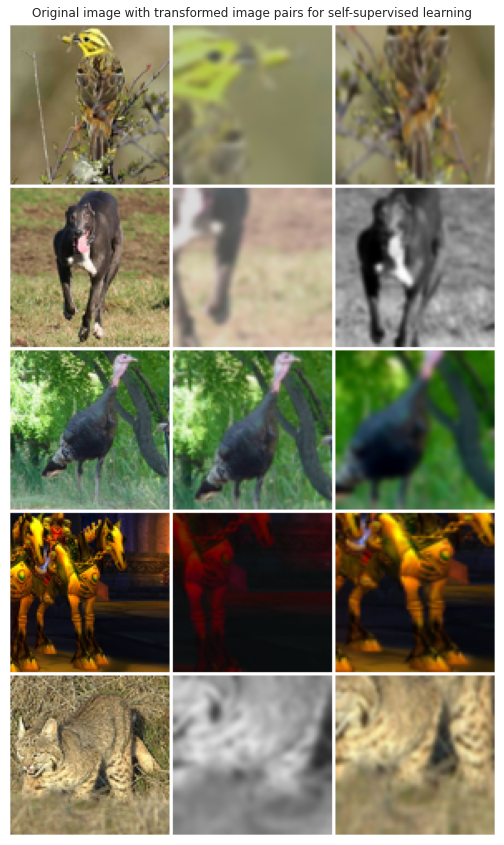

In [32]:
# Pulling original image and transformed pair from datasets
imgs = []
for i in range(5):
    imgs.append(train_data[i][0])
    imgs += validation_data[i][0]
imgs = torch.stack(imgs, dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=3, normalize=True, pad_value=1)
img_grid = img_grid.permute(1, 2, 0)

# Creating figure and axes for plotting
fig, ax = plt.subplots(figsize=[10,15])
# Displaying torchvision image grid
ax.imshow(img_grid)

# Matplotlib plot formatting
ax.set(title='Original image with transformed image pairs for self-supervised learning')
ax.set_axis_off()
plt.show()
plt.close()

## SimCLR Model Implementation

The neural network for SimCLR is implemented here using PyTorch-Lightning. This implementation is taken from the paper [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf) and adapted from the tutorial example provided by PyTorch.

We will start by training a self-supervised model using the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset. The code below shows how to take advantage of the PyTorch Lightning LightningModule to reduce boilerplate and create models efficiently. This parent class is also used later for the DownstreamLR model. For the model we need a convnet backbone to act as our encoder network, here using ResNET18 like the official example, and we also need a projection head comprised of a very simple mlp when training the model. This projection head is not needed for downstream applications.

For the loss function, the authors use the InfoNCE loss introduced by the paper [Representation Learning with Contrastive Predictive Coding](https://arxiv.org/pdf/1807.03748.pdf). The implementation I have gone with is different than how it was shown in the original tutorial, however I validated the outputs and it returns the same values but is more performant.

The AdamW optimizer is used which is generally a good choice, and we add a cosine annealing learning rate scheduler to help with convergence.

The methods on the class are named according to the documentation for LightningModule and should generally be kept the same to take advantage of features in PyTorch Lightning.

In [4]:
class SimCLR(pl.LightningModule):
    """
    SimCLR model implementation
    """
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        # Defining the base encoder network
        self.convnet = torchvision.models.resnet18(num_classes=4 * hidden_dim)
        # Defining the projection head
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        # Setting up AdamW as the optimizer
        optimizer = optim.AdamW(
            self.parameters(), 
            lr=self.hparams.lr, 
            weight_decay=self.hparams.weight_decay
        )
        # Adding learning rate scheduling to the optimizer
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=self.hparams.max_epochs, 
            eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # Getting images from the batch and applying convnet
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        feats = self.convnet(imgs)
        # Normalizing convnet output for calculating loss
        feats = F.normalize(feats, dim=-1)
        N = feats.shape[0]

        # Labels along the matrix diagonal, boolean mask for calculations
        labels = torch.eye(N, device=feats.device)
        mask = labels.type(torch.bool)
        # Positive examples shifted by N // 2 in the data
        labels = labels.roll(shifts=N // 2, dims=0)
        shift_mask = labels.type(torch.bool)

        # Compute cosine similarity and mask labels
        logits = feats @ feats.transpose(-2, -1)
        logits.masked_fill_(mask, -9e15)
        # Scale by temperature
        logits = logits / self.hparams.temperature

        # Combine positive examples with similarity predictions for ranking
        ranking = torch.cat([
                logits[shift_mask][:, None], 
                logits.masked_fill(shift_mask, -9e15)
            ], dim=-1
        )
        # Sort ranking and get position of best similarity (argmin)
        ranking = ranking.argsort(dim=-1, descending=True).argmin(dim=-1)
        loss = F.cross_entropy(logits, labels, reduction='mean')

        # Log metrics for model based on mode
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc_top1', (ranking == 0).float().mean())
        self.log(f'{mode}_acc_top5', (ranking < 5).float().mean())
        self.log(f'{mode}_acc_mean_pos', 1 + ranking.float().mean())

        return loss

    def training_step(self, batch, batch_idx):
        # Log metrics and return loss value for training
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        # Log metrics for validation
        self._calculate_loss(batch, mode="val")

## SimCLR Training

Along with defining transformation and model classes, we also need to define a training class for convenience. This class subclasses pl.Trainer and we set it up to use pretrained models when available, including downloading models from Github. We will also create a very similar trainer class for the upcoming DownstreamLR model, which is nice since for development purposes it becomes a quick copy-paste operation.

With the trainer class we can now fit our model and start looking to downstream applications. If you choose to disable downloads for the pretrained model to train it yourself, be warned that it can take a very long time, even with GPUs. Each epoch was on the order of a few minutes and it takes hundreds of epochs to converge for this model and LR scheduler.

In [5]:
class SimCLRTrainer(pl.Trainer):
    """
    SimCLR trainer class
    """
    def __init__(self, batch_size, max_epochs, download=False, **kwargs):
        super().__init__(
            default_root_dir=Path('models') / 'SimCLR',
            accelerator=str(device) if str(device) in {'mps', 'cpu'} else 'auto',
            max_epochs=max_epochs,
            callbacks=[
                ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
                LearningRateMonitor("epoch")
            ]
        )

        self.batch_size = batch_size
        self.is_trained = False
        # Attempt to load pre-trained model
        self.model = self.load_pretrained(download)
        # Fall back to new SimCLR instance if self.model is None
        if not self.model:
            self.model = SimCLR(max_epochs=max_epochs, **kwargs)

    def load_pretrained(self, download=False):
        ckpt_path = Path('models') / 'SimCLR.ckpt'
        # Download pre-trained model from Github
        if download:
            self.download_pretrained(ckpt_path)

        # Load pre-trained model from disk if file exists
        if os.path.isfile(ckpt_path):
            self.is_trained = True
            LOG.info(f'Loading pre-trained model from path: {ckpt_path}')
            return SimCLR.load_from_checkpoint(ckpt_path)

    def download_pretrained(self, ckpt_path):
        # Pre-trained model checkpoint from my Github repo
        pretrained_url = 'https://raw.githubusercontent.com/pciunkiewicz/ensf-619/master/tutorial/models/SimCLR.ckpt'
        os.makedirs('models', exist_ok=True)

        # Only download the file if not found on disk; no overwrite
        if not os.path.isfile(ckpt_path):
            try:
                LOG.info(f'Downloading pre-trained model from {pretrained_url}')
                urllib.request.urlretrieve(pretrained_url, ckpt_path)
            except HTTPError as exception:
                LOG.error(exception)

    def fit(self, train, val):
        # Check if pre-trained model has been loaded
        if not self.is_trained:
            # Create PyTorch DataLoaders for training and validation sets
            train_loader = data.DataLoader(
                train,
                batch_size=self.batch_size,
                shuffle=True,
                drop_last=True,
                pin_memory=True,
                num_workers=NUM_WORKERS,
            )
            val_loader = data.DataLoader(
                val,
                batch_size=self.batch_size,
                shuffle=False,
                drop_last=False,
                pin_memory=True,
                num_workers=NUM_WORKERS,
            )

            super().fit(self.model, train_loader, val_loader)
            self.model = SimCLR.load_from_checkpoint(self.checkpoint_callback.best_model_path)
        else:
            LOG.info('Model is already trained; returning pre-trained model.')
        return self.model


In [6]:
# Instantiating trainer and fitting the model
trainer = SimCLRTrainer(
    batch_size=256, 
    max_epochs=500, 
    download=True,
    hidden_dim=128, 
    lr=5e-4, 
    temperature=0.07, 
    weight_decay=1e-4
)
simclr_model = trainer.fit(unlabeled_data, validation_data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:tutorial.ipynb:Loading pre-trained model from path: models/SimCLR.ckpt
INFO:tutorial.ipynb:Model is already trained; returning pre-trained model.


## Downstream Applications - Logistic Regression

With a trained SimCLR model, we can now turn to downstream applications. We will try doing some image classification on the labeled images within the STL10 dataset as this seems like the logical starting point. We define a model sublassing LighningModule like before, however this time the logic is much simpler since we are only implementing logistic regression instead of SimCLR which is more complicated.

The model itself is a very simple linear layer without activations, using the AdamW optimizer as before and simple cross entropy for the loss function. As with the other model, metrics are logged conveniently during.

We also define the downstream trainer, with heavy overlap to the SimCLR trainer. One addition is the custom test method to compute metrics for benchmarking our downstream tasks.

In [11]:
class DownstreamLR(pl.LightningModule):
    """
    Logistic regression model implementation
    """
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Simple linear layer without non-linear activation
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        # Setting up AdamW as the optimizer
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        # Adding learning rate scheduling to the optimizer
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[int(self.hparams.max_epochs*0.6), int(self.hparams.max_epochs*0.8)],
            gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # Get encoded feature maps and labels from the batch
        X, y = batch
        # Predict classes using linear model
        y_pred = self.model(X)
        # Calculate cross entropy loss across predictions
        loss = F.cross_entropy(y_pred, y)
        # Calculate accuracy across predictions
        acc = (y == y_pred.argmax(dim=-1)).type(torch.float).mean()

        # Log metrics for model based on mode
        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)

        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')


class DownstreamLRTrainer(pl.Trainer):
    """
    Downstream logistic regression trainer class
    """
    def __init__(self, batch_size, max_epochs, name='DownstreamLR', download=False, **kwargs):
        super().__init__(
            default_root_dir=Path('models') / name,
            accelerator=str(device) if str(device) in {'mps', 'cpu'} else 'auto',
            max_epochs=max_epochs,
            callbacks=[
                ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                LearningRateMonitor("epoch")
            ]
        )

        self.name = name
        self.batch_size = batch_size
        self.is_trained = False
        # Attempt to load pre-trained model
        self.model = self.load_pretrained(download)
        # Fall back to new DownstreamLR instance if self.model is None
        if not self.model:
            self.model = DownstreamLR(max_epochs=max_epochs, **kwargs)

    def load_pretrained(self, download=False):
        ckpt_path = Path('models') / f'{self.name}.ckpt'
        # Download pre-trained model from Github
        if download:
            self.download_pretrained(ckpt_path)

        # Load pre-trained model from disk if file exists
        if os.path.isfile(ckpt_path):
            self.is_trained = True
            LOG.info(f'Loading pre-trained model from path: {ckpt_path}')
            return DownstreamLR.load_from_checkpoint(ckpt_path)

    def download_pretrained(self, ckpt_path):
        # Pre-trained model checkpoint from my Github repo
        pretrained_url = f'https://raw.githubusercontent.com/pciunkiewicz/ensf-619/master/tutorial/models/{self.name}.ckpt'
        os.makedirs('models', exist_ok=True)

        # Only download the file if not found on disk; no overwrite
        if not os.path.isfile(ckpt_path):
            try:
                LOG.info(f'Downloading pre-trained model from {pretrained_url}')
                urllib.request.urlretrieve(pretrained_url, ckpt_path)
            except HTTPError as exception:
                LOG.error(exception)

    def fit(self, train, val):
        # Create PyTorch DataLoaders for training and validation sets
        self.train_loader = data.DataLoader(
            train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        self.val_loader = data.DataLoader(
            val,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        
        # Check if pre-trained model has been loaded
        if not self.is_trained:
            super().fit(self.model, self.train_loader, self.val_loader)
            self.model = DownstreamLR.load_from_checkpoint(self.checkpoint_callback.best_model_path)
        else:
            LOG.info('Model is already trained; returning pre-trained model.')
        return self.model

    def test(self, mode, **kwargs):
        # Check that mode is valid
        assert mode in {'train', 'val'}
        if mode == 'train':
            loader = self.train_loader
        elif mode == 'val':
            loader = self.val_loader
        # Use parent class test method and return results
        return super().test(self.model, loader, **kwargs)


## Preparing Data for Logistic Regression

Unlike training an image classification model from scratch, we need to first apply our trained SimCLR encoder backbone to the images to extract the feature representations before performing logistic regression. If our learned representations are strong, we can get great performance boosts for downstream tasks. We apply the data preparation to our two datasets which we want to experiment with for downstream applications.

In [8]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Make a copy in-memory of SimCLR encoder backbone
    encoder = deepcopy(model.convnet)
    # Remove projection head from encoder
    encoder.fc = nn.Identity()
    encoder.eval()
    encoder.to(device)

    # Initialize DataLoader
    data_loader = data.DataLoader(
        dataset, 
        batch_size=64, 
        num_workers=NUM_WORKERS, 
        shuffle=False, 
        drop_last=False
    )

    X, y = [], []
    # Iterate across all batches in the DataLoader
    for imgs, labels in tqdm(data_loader):
        imgs = imgs.to(device)
        # Apply encoder to images
        encoded_features = encoder(imgs).detach().cpu()
        X.append(encoded_features)
        y.append(labels)

    # Concatenate all encoded image feature maps and labels
    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)

    # Sort images by labels for organization
    y, idxs = y.sort()
    X = X[idxs]

    return data.TensorDataset(X, y)


train_encoded = prepare_data_features(simclr_model, train_data)
test_encoded = prepare_data_features(simclr_model, test_data)

cars_train_encoded = prepare_data_features(simclr_model, cars_train)
cars_test_encoded = prepare_data_features(simclr_model, cars_test)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

## Fitting Downstream Models

Now with our data prepared, we can try training new classification models with the feature representations from our self-supervised model. Training very simple models like these is dramatically faster than training a new image model from scratch, so there are many benefits to this approach. Once trained, we can compute metrics on the train and test sets to see how our models perform. We will do this for both datasets and see how the predictive performance looks.

In [15]:
# Instantiating trainer and fitting the model
trainer = DownstreamLRTrainer(
    batch_size=64, 
    max_epochs=100, 
    download=True,
    feature_dim=train_encoded.tensors[0].shape[1],
    num_classes=10,
    lr=1e-3, 
    weight_decay=1e-3
)
downstream_model = trainer.fit(train_encoded, test_encoded)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
train_result = trainer.test('train')
val_result = trainer.test('val')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9122596383094788
        test_loss           0.27176719903945923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8142499923706055
        test_loss           0.5539460778236389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [23]:
# Instantiating trainer and fitting the model
trainer = DownstreamLRTrainer(
    batch_size=64, 
    max_epochs=100, 
    download=True,
    name='CarsDownsteamLR',
    feature_dim=cars_train_encoded.tensors[0].shape[1],
    num_classes=196,
    lr=1e-3, 
    weight_decay=1e-3
)
downstream_model = trainer.fit(cars_train_encoded, cars_test_encoded)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 100 K 
---------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.402     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [24]:
train_result = trainer.test('train')
val_result = trainer.test('val')

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7876476645469666
        test_loss           1.3040131330490112
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.15060316026210785
        test_loss            4.368003845214844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Downstream Application Results

From the results, we can see that the models trained very fast! Using the lower-grade GPUs on Google Colab it took around 1 second per epoch for the STL10 model and 2 seconds per epoch for the Stanford Cars model. This is orders of magnitude faster than the convnet in our SimCLR model which took multiple minutes per epoch to train.

Performance wise, the STL10 downstream classification application was quite good, reaching 91% accuracy on the training set and 81% accuracy on the test set. This indicates that there may have been some mild overfitting, but 81% validation accuracy is still fairly good for 10-class classification. Unfortunately I did not have enough time to explore training an image network from scratch to compare against, however the PyTorch Lightning includes such an analysis and they achieved 73% validation accuracy with extensive overfitting.

Performance on the Stanford Cars dataset was not as great as on STL10, likely attributed to the large number of classes and the fact that images for self-supervised learning were taken from STL10. The training performance was respectable at 79% accuracy, however the test accuracy was significantly worse at just 15%. Due to the large number of classes, it would be worthwhile to explore top 5 or top 10 accuracy, which I suspect would be much higher due to the similarity between certain classes.

## Conclusion

In this tutorial, we demonstrated how to implement self-supervised learning in PyTorch using PyTorch Lightning. We covered topics such as dataset loading, processing, model development, training, validating, loss functions, checkpointing, and learning rate scheduling. The official tutorial from PyTorch Lighting contains a bunch more great information about the underlying SimCLR method and further investigation which I greatly recommend!